### LOAD DATA & PREP FOR FMM

In [27]:
# Load data
df = pd.read_csv("../data/poster3_data.csv")

# Keep the original budget category column
budget_col = "from_budget_category"  # adjust if it's named slightly differently

# One-hot encode genres and subgenres
from sklearn.preprocessing import MultiLabelBinarizer

mlb_genre = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb_genre.fit_transform(df["genres"]), columns=[f"genre_{g}" for g in mlb_genre.classes_])

mlb_subgenre = MultiLabelBinarizer()
subgenre_encoded = pd.DataFrame(mlb_subgenre.fit_transform(df["subgenres"]), columns=[f"subgenre_{s}" for s in mlb_subgenre.classes_])

# Numeric features
df_numeric = df[["from_runtimeMinutes", "from_averageRating", "from_numVotes", "from_budget", "from_revenue"]]

# Final dataset
X = pd.concat([df_numeric.reset_index(drop=True), genre_encoded, subgenre_encoded], axis=1).dropna()

# Match labels to rows
budget_labels = df.loc[X.index, budget_col].reset_index(drop=True)

# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### RUN FMM FOR DIFFERENT K

In [15]:
from sklearn.mixture import GaussianMixture
import pandas as pd
from collections import Counter

def fit_fmm_with_distribution(X_scaled, n_components):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_scaled)

    aic = round(gmm.aic(X_scaled), 2)
    bic = round(gmm.bic(X_scaled), 2)

    # Get cluster assignments
    labels = gmm.predict(X_scaled)
    distribution = dict(Counter(labels))  # {cluster_id: count}

    return {
        "k": n_components,
        "aic": aic,
        "bic": bic,
        "distribution": distribution
    }

# Run for each K
k_list = [20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 200, 500]
results = [fit_fmm_with_distribution(X_scaled, k) for k in k_list]

# Turn into a DataFrame for viewing
perf_df = pd.DataFrame(results)

perf_df.head()

,k,aic,bic,distribution
0,20,-981902.01,-670240.09,"{2: 224, 18: 617, 12: 376, 19: 199, 4: 397, 7:..."
1,25,-1128128.75,-738549.74,"{2: 275, 15: 108, 1: 221, 11: 193, 14: 658, 19..."
2,30,-1201499.62,-734003.51,"{2: 315, 15: 51, 1: 219, 29: 188, 25: 306, 19:..."
3,35,-1239259.96,-693846.77,"{31: 181, 22: 108, 1: 183, 11: 56, 25: 315, 19..."
4,40,-1255812.96,-632482.67,"{31: 180, 22: 101, 1: 145, 11: 68, 25: 164, 37..."


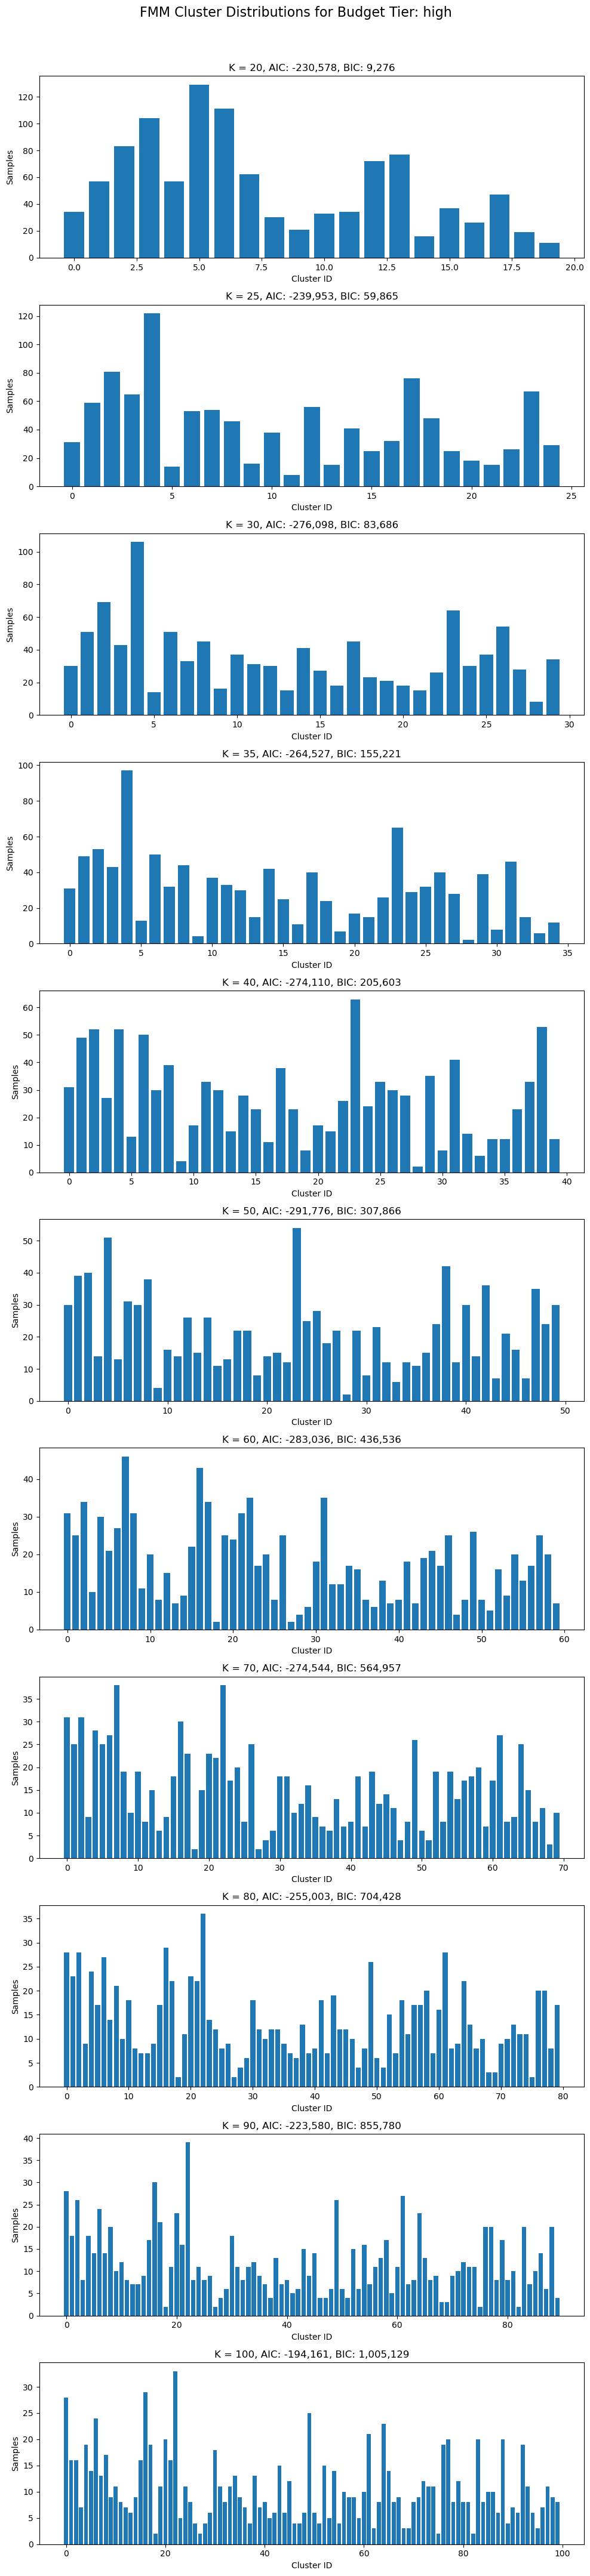

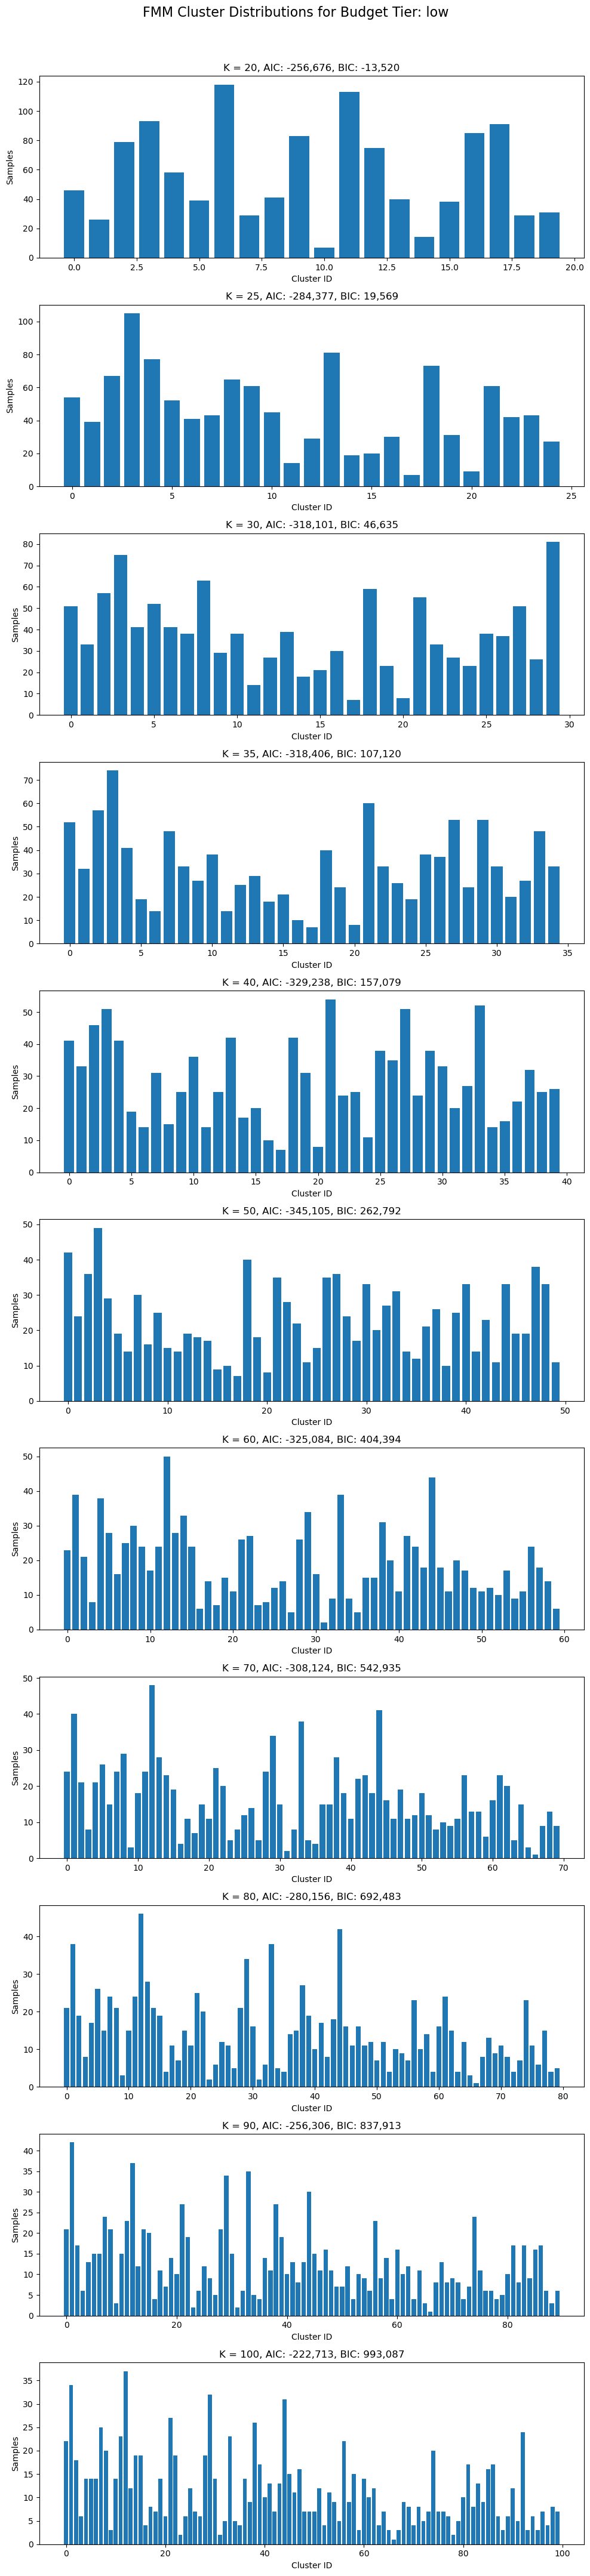

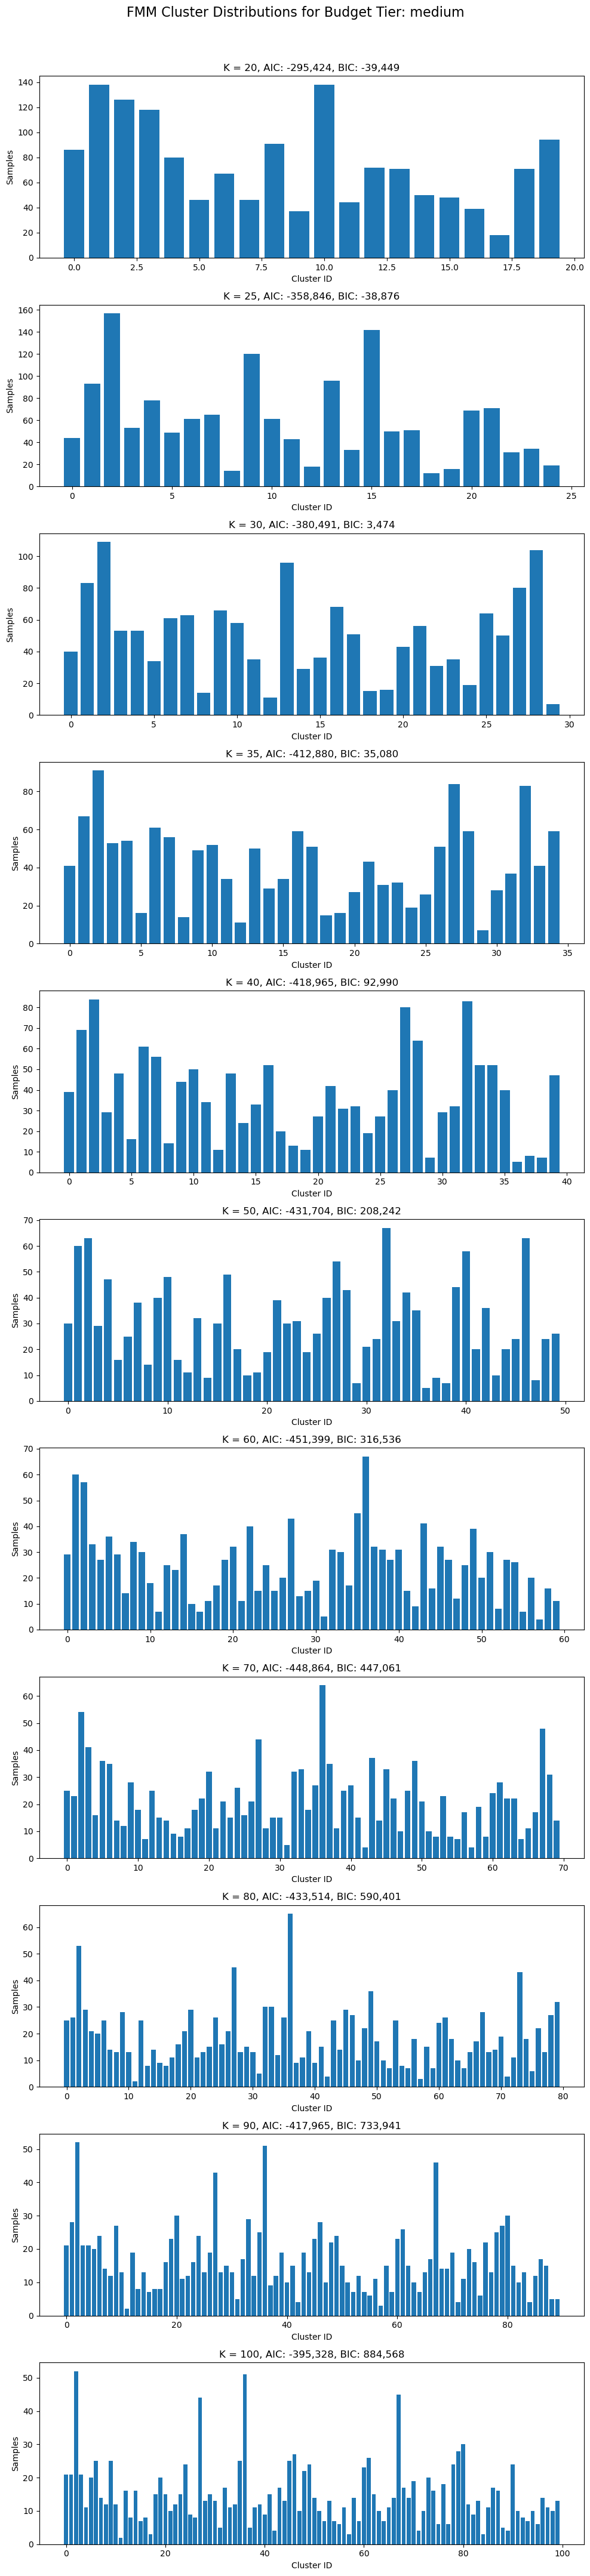

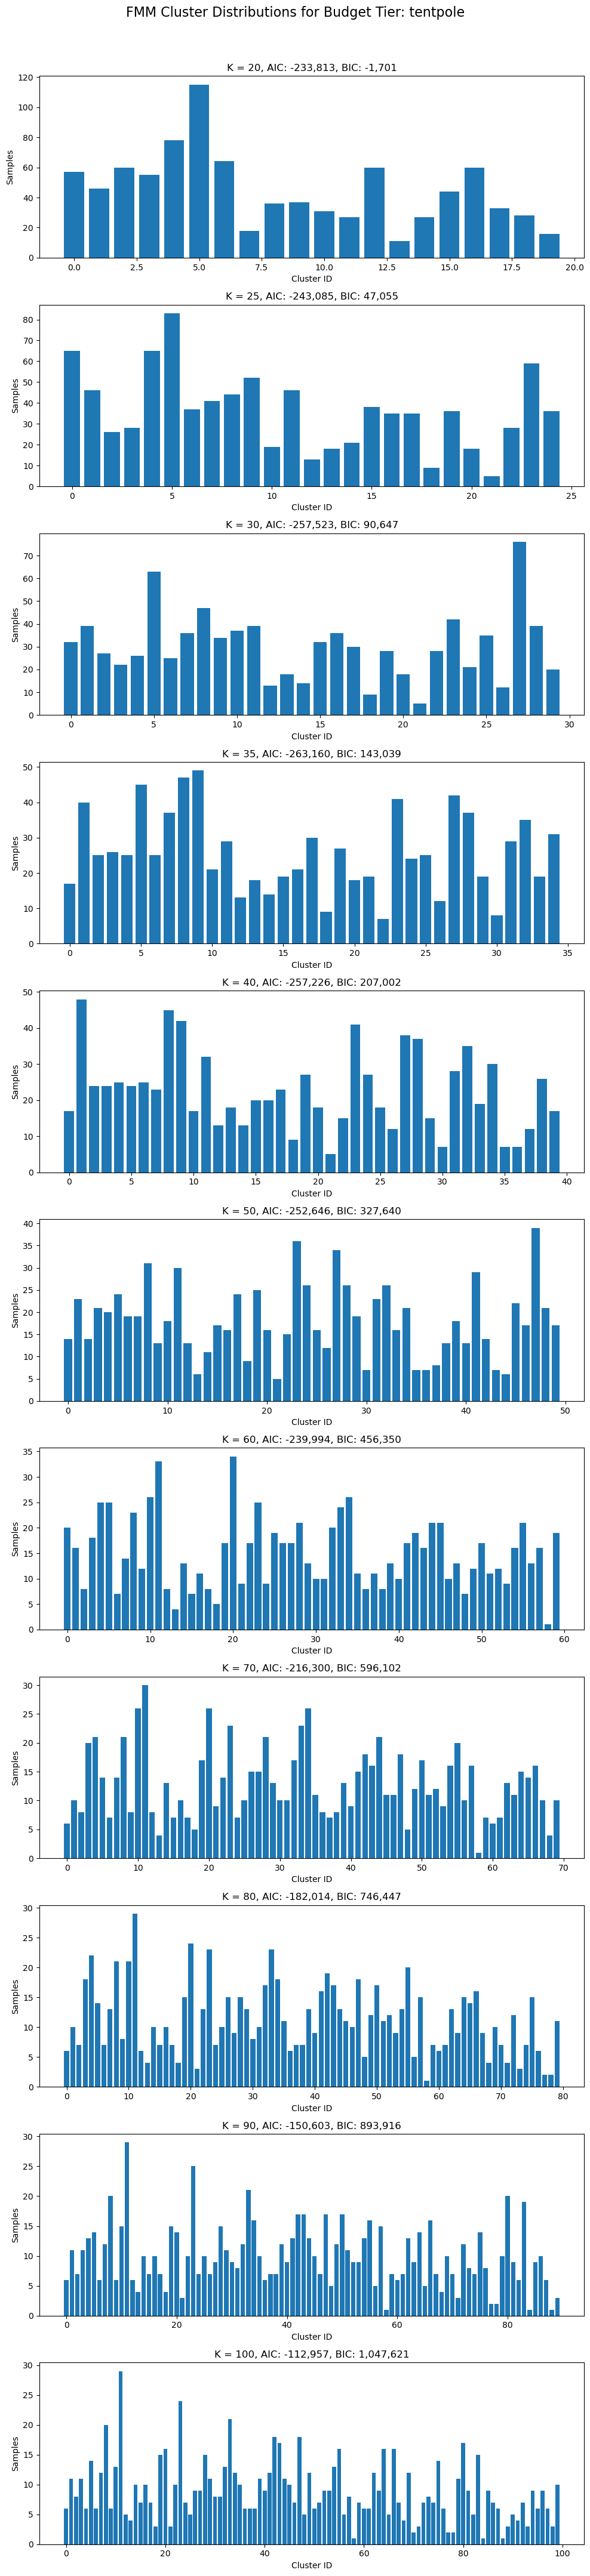

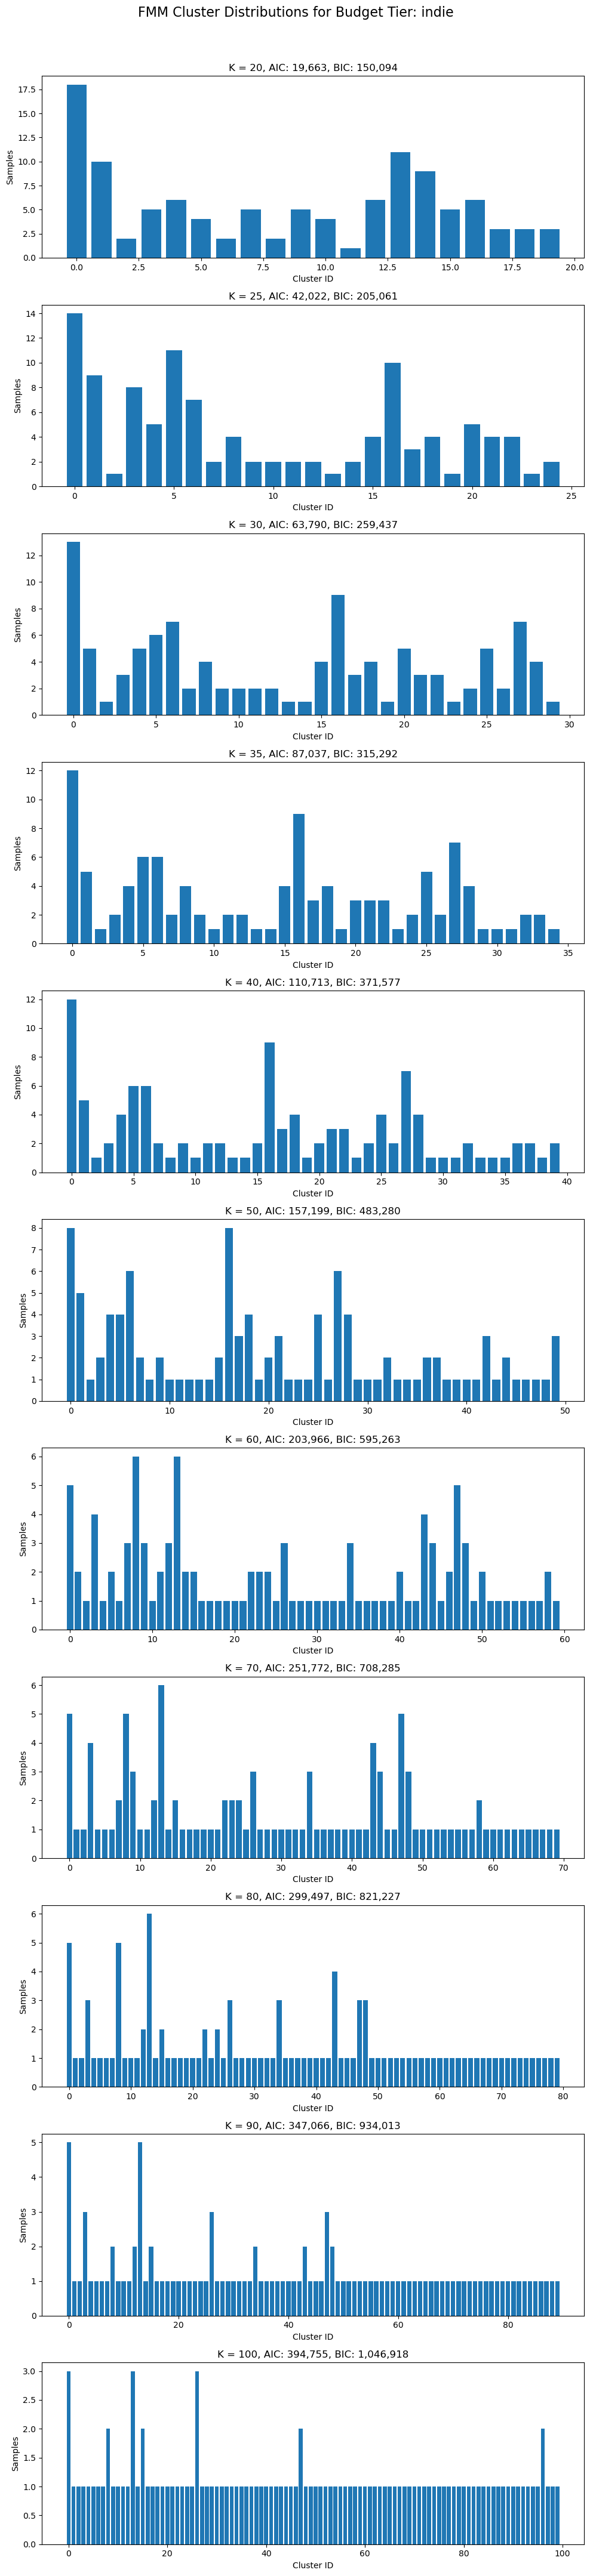

In [37]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from collections import Counter
import warnings
import os

os.environ["OMP_NUM_THREADS"] = "1"  # or "1", or however many threads you want to use
warnings.filterwarnings("ignore", category=UserWarning)

# Parameters
k_list = [20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]
budget_buckets = budget_labels.unique()
full_results = {}  # nested dict: {budget_tier: [results_per_k]}

# Fit FMM for each budget tier and K
for bucket in budget_buckets:
    mask = budget_labels == bucket
    X_bucket = X_scaled[mask]

    results = []
    for k in k_list:
        gmm = GaussianMixture(n_components=k, random_state=0)
        gmm.fit(X_bucket)

        labels = gmm.predict(X_bucket)
        distribution = dict(Counter(labels))

        results.append({
            "k": k,
            "aic": gmm.aic(X_bucket),
            "bic": gmm.bic(X_bucket),
            "distribution": distribution
        })
    
    full_results[bucket] = results

# Plot cluster distributions per budget tier
for bucket, results in full_results.items():
    fig, axs = plt.subplots(len(results), 1, figsize=(10, 4 * len(results)), sharex=False)
    fig.suptitle(f"FMM Cluster Distributions for Budget Tier: {bucket}", fontsize=16)

    for i, row in enumerate(results):
        k = row["k"]
        aic = row["aic"]
        bic = row["bic"]
        dist = row["distribution"]

        axs[i].bar(dist.keys(), dist.values())
        axs[i].set_title(f"K = {k}, AIC: {aic:,.0f}, BIC: {bic:,.0f}")
        axs[i].set_xlabel("Cluster ID")
        axs[i].set_ylabel("Samples")

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # leaves space for suptitle
    plt.savefig(f"../plots/fmm/{bucket}_fmm_cluster_distributions.png")
    plt.show()


In [ ]:
# filter by budget bucket

# Run for each K
k_list = [20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 200, 500]
results = [fit_fmm_with_distribution(X_scaled, k) for k in k_list]

# Turn into a DataFrame for viewing
perf_df = pd.DataFrame(results)

perf_df.head()

In [23]:
X.columns

Index(['from_runtimeMinutes', 'from_averageRating', 'from_numVotes',
       'from_budget', 'from_revenue', 'genre_ ', 'genre_,', 'genre_-',
       'genre_A', 'genre_B', 'genre_C', 'genre_D', 'genre_F', 'genre_H',
       'genre_M', 'genre_R', 'genre_S', 'genre_T', 'genre_W', 'genre_a',
       'genre_c', 'genre_d', 'genre_e', 'genre_g', 'genre_h', 'genre_i',
       'genre_l', 'genre_m', 'genre_n', 'genre_o', 'genre_p', 'genre_r',
       'genre_s', 'genre_t', 'genre_u', 'genre_v', 'genre_y', 'subgenre_ ',
       'subgenre_,', 'subgenre_-', 'subgenre_1', 'subgenre_C', 'subgenre_a',
       'subgenre_b', 'subgenre_c', 'subgenre_d', 'subgenre_e', 'subgenre_f',
       'subgenre_g', 'subgenre_h', 'subgenre_i', 'subgenre_j', 'subgenre_k',
       'subgenre_l', 'subgenre_m', 'subgenre_n', 'subgenre_o', 'subgenre_p',
       'subgenre_q', 'subgenre_r', 'subgenre_s', 'subgenre_t', 'subgenre_u',
       'subgenre_v', 'subgenre_w', 'subgenre_x', 'subgenre_y', 'subgenre_z'],
      dtype='object')

In [26]:
df.columns

Index(['Unnamed: 0', 'from_tconst', 'from_label', 'from_title', 'from_year',
       'from_runtimeMinutes', 'from_averageRating', 'from_numVotes',
       'from_budget', 'from_revenue', 'relationship', 'to_label', 'to_name',
       'to_id', 'to_gender', 'to_popularity', 'to_adult', 'genres',
       'subgenres', 'from_year_adj', 'from_budget_adj', 'from_revenue_adj',
       'from_budget_category', 'profit', 'profit_percent_gain'],
      dtype='object')